# Preliminary Data Exploration

This is where we'll do our primary data exploration phase to summarize and extract relevant trends, findings, characteristics or features about the dataset. 

We'll also address abnormalities or characteristics about the data that stand out, in addition to some feature engineering.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")

from matplotlib import cm
from scipy.stats import norm, skew

In [2]:
train = pd.read_csv("./train.csv")
train_ID = train["Id"]

test = pd.read_csv("./test.csv")
test_ID = test["Id"] 

# Summary statistics for SalePrice
train["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

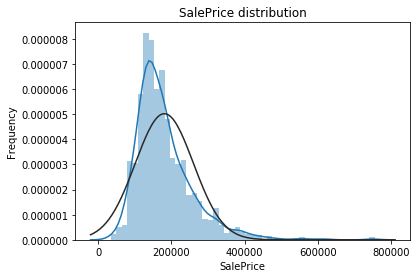

In [3]:
sns.distplot(train.SalePrice,fit=norm)
plt.ylabel("Frequency")
plt.title("SalePrice distribution")
(mu, sigma) = norm.fit(train["SalePrice"])
plt.show()

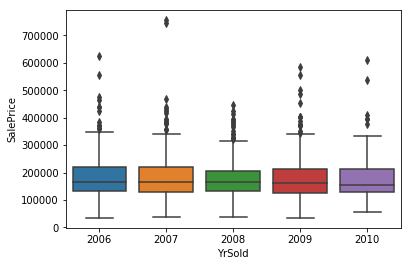

In [4]:
sns.boxplot(train.YrSold,train.SalePrice)
plt.show()

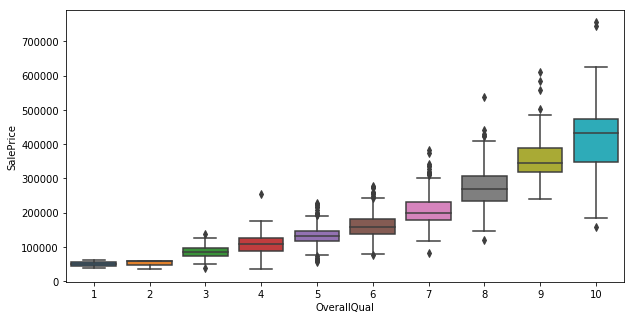

In [5]:
var = 'OverallQual'

def show_boxplot(var):
    data = pd.concat([train['SalePrice'], train[var]], axis=1)
    plt.figure(figsize=(10,5))
    sns.boxplot(x=var, y="SalePrice", data=data)
    plt.show()

show_boxplot(var)

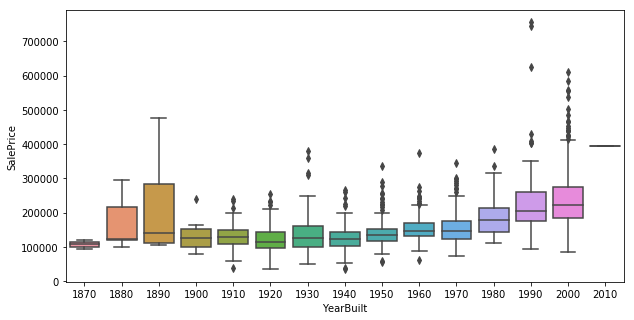

In [6]:
#Group YearBuilt by decade
var = 'YearBuilt'
data = pd.concat([train['SalePrice'], (train[var]//10)*10], axis=1)
plt.figure(figsize=(10,5))
sns.boxplot(x=var, y="SalePrice", data=data)
plt.show()

We assume that neighborhood, year sold and overall condition of the house are important factors that will affect the sale price. We took a look at the boxplots for each variable to see the values at each quartile.

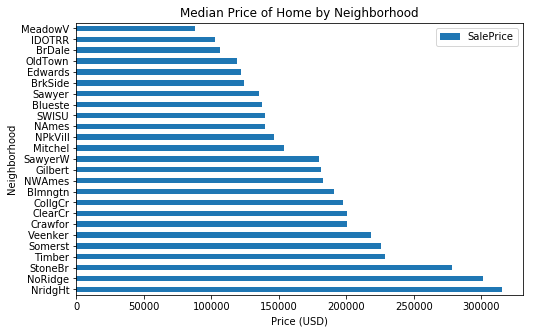

In [7]:
a = pd.DataFrame(train.groupby('Neighborhood')['SalePrice'].median().sort_values(ascending = False))
a.plot.barh(figsize = (8,5))
plt.xlabel('Price (USD)')
plt.title('Median Price of Home by Neighborhood')
plt.show()

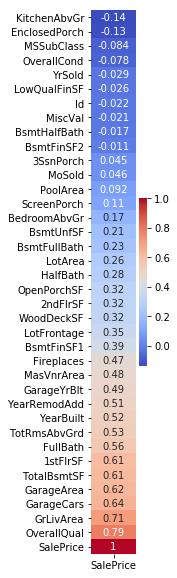

In [8]:
corrmat = train.corr()
indices = corrmat.loc[:,'SalePrice'].copy()
a = pd.DataFrame(indices.sort_values())
plt.figure(figsize=(1,10))
sns.heatmap(a, annot=True, cmap=cm.coolwarm)
plt.show()

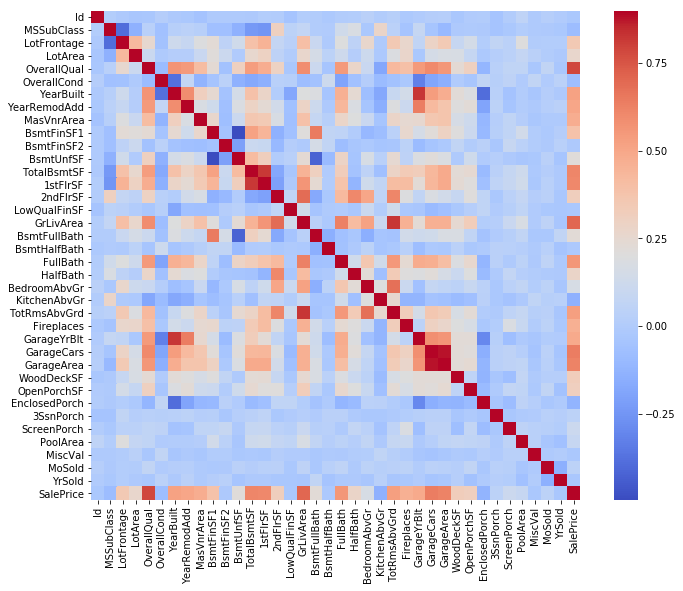

In [9]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.9, square=True, cmap=cm.coolwarm)
plt.show()